In [7]:
import sys
sys.path.append('helpers/')

from pprint import pprint
import scipy.io as scio
from torch.utils.data import Dataset, DataLoader
from eegdProcessors import getLabeledEpochs, DownSample, BPButter4, filter_removeOutliers
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

In [8]:
eeg_1s_raw = scio.loadmat('./data/subject_1_eeg_separated_epochs_1s.mat')

In [65]:
len(getLabeledEpochs(eeg_1s_raw, 1/3))

1220

In [67]:
# Definiranje klase pyTorch dataseta za eeg podatke

class eegDataset(Dataset):
    labels = ('Target', 'non Target')

    def __init__(self, eeg_raw, ratio, seed, transform=None, filterChain = []):
        self.epochs = getLabeledEpochs(eeg_raw, ratio, seed=seed, filterChain=filterChain)
        self.transform = transform

    def __len__(self):
        return len(self.epochs)

    def __getitem__(self, idx):
        label = self.epochs[idx][0]
        epoch = self.epochs[idx][1]

        # Ako je dan transformer podataka
        # poslati podatke kroz njega
        if self.transform:
            epoch = self.transform(epoch)

        return torch.from_numpy(epoch), label

In [68]:
# Definiranje dataloadera

downsapling = 8
# Prvo se podatci downsampleaju downsapling puta
# zatim se filtriraju PP Butt filtrom 4. reda od 0.1hz do 20hz
training_data = eegDataset(eeg_1s_raw, 1/3, 'abc', transform=transforms.Compose([
    DownSample(downsapling),
    BPButter4(0.1, 20, 512/downsapling)
]), filterChain=[
    filter_removeOutliers
])


train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)

Feature batch shape: torch.Size([4, 16, 64])
Labels batch shape: torch.Size([4])


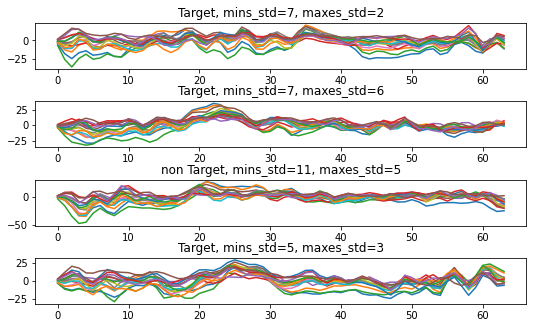

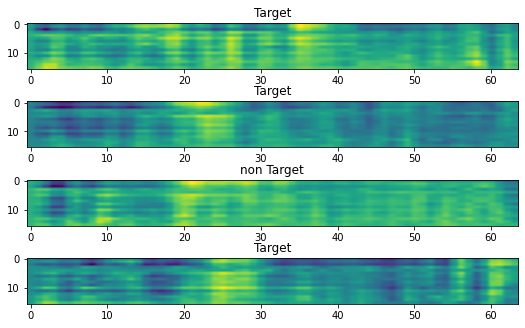

In [81]:
# Vizualizacija jednog batcha

train_ephs, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_ephs.size()}")
print(f"Labels batch shape: {train_labels.size()}")

fig2, ax2 = plt.subplots(len(train_ephs))
for key, item in enumerate(train_ephs):
    # Racunanje standardne devijacije maximuma i minimuma mjerenja elektroda
    mins = []
    maxes = []
    for line in item:
        ax2[key].plot(line)
        mins.append(line.min())
        maxes.append(line.max())
    mins = np.array(mins)
    maxes = np.array(maxes)
    label = training_data.labels[train_labels[key]] + ", mins_std=" + str(int(mins.std())) + ", maxes_std=" + str(int(maxes.std()))
    ax2[key].set_title(label)
    ax2[key].set_aspect('auto')

fig2.set_figwidth(2.2*len(train_ephs))
fig2.set_figheight(len(train_ephs))
fig2.subplots_adjust(top=1.1, hspace=0.7)



fig, ax = plt.subplots(len(train_ephs))
for key, item in enumerate(train_ephs):
    label = training_data.labels[train_labels[key]]
    ax[key].set_title(label)
    ax[key].imshow(item)
    ax[key].set_aspect('auto')

fig.set_figwidth(2.2*len(train_ephs))
fig.set_figheight(len(train_ephs))
fig.subplots_adjust(top=1.1, hspace=0.7)

